# Using a PyTorch CNN to classify animal images

Data link: https://www.kaggle.com/datasets/likhon148/animal-data

The purpose of this notebook is as a portfolio piece to show understanding of CNN models and implimentation for classification of images. 


** NOTE **
This is "version 1" and there seems to be an issue of the mode sticking at 0.6 for validation accuracy when training and this will be addressed at a later date.

### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt
import numpy as np

### Set device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


The dataset I am using is pretty small so I will be randomly altering the images according to some predefined rules every time the model sees them to make it more robust.

In [3]:
def load_data(data_path):
    transform = transforms.Compose([
        transforms.Resize([64, 64]),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        #transforms.RandomCrop(size=[128, 128], padding=4),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        #transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor()
    ])
    image_folder = datasets.ImageFolder(data_path, transform=transform)
    torch.manual_seed(1)
    
    train_data, val_data, test_data = random_split(image_folder, [0.6,0.2,0.2])
    
    train_data_loader = DataLoader(train_data, batch_size=32, shuffle="True")
    val_data_loader = DataLoader(val_data, batch_size=32, shuffle="True")
    test_data_loader = DataLoader(test_data, batch_size=32, shuffle="True")
    
    return train_data_loader, val_data_loader, test_data_loader

In [4]:
data_path = "animal_data"
train_data_loader, valid_data_loader, test_data_loader = load_data(data_path)

The small size of the dataset will require a small model to prevent overfitting.

In [5]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64*16*16, 128),  # Ensured this matches the output of flatten
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 64),
    nn.Dropout(0.5),
    nn.Linear(64, 15)
)

Define the loss function and the optimizer

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Move the model to the device

In [7]:
model.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=16384, out_features=128, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=128, out_features=64, bias=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=64, out_features=15, bias=True)
)

In [8]:
#Training loop
def train(model, num_epochs, train_dataloader, valid_dataloader):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device) # move to device
            
            optimizer.zero_grad()
            
            #output = model[:7](x_batch)  # Execute up to the layer before 'fc1'
            #print(f'Output shape before fc1: {output.shape}')  # Should show the shape
            #output = model[7:](output)  # Continue with 'fc1' and the rest
            
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dataloader.dataset)
        accuracy_hist_train[epoch] /= len(train_dataloader.dataset)
            
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device) #move to device
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()* y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_dataloader.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dataloader.dataset)
        if epoch % 50 == 0:
            print(f"Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}")
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

Here I'm training the model for 300 epochs. This 

In [ ]:
torch.manual_seed(1)
start = time.time()

num_epochs=300
hist = train(model, num_epochs, train_data_loader, valid_data_loader)

end = time.time()
print(f"Time taken to train: {end - start} seconds")

Epoch 1 accuracy: 0.6975 val_accuracy: 0.6067
Epoch 6 accuracy: 0.7078 val_accuracy: 0.6144
Epoch 11 accuracy: 0.7069 val_accuracy: 0.6272
Epoch 16 accuracy: 0.7112 val_accuracy: 0.6427
Epoch 21 accuracy: 0.7155 val_accuracy: 0.6427
Epoch 26 accuracy: 0.7224 val_accuracy: 0.6144
Epoch 31 accuracy: 0.7027 val_accuracy: 0.6401
Epoch 36 accuracy: 0.7164 val_accuracy: 0.6118
Epoch 41 accuracy: 0.7266 val_accuracy: 0.6427
Epoch 46 accuracy: 0.7344 val_accuracy: 0.6324
Epoch 51 accuracy: 0.7232 val_accuracy: 0.6298
Epoch 56 accuracy: 0.7541 val_accuracy: 0.6452
Epoch 61 accuracy: 0.7207 val_accuracy: 0.6427
Epoch 66 accuracy: 0.7241 val_accuracy: 0.6324


Plot the trainig history.

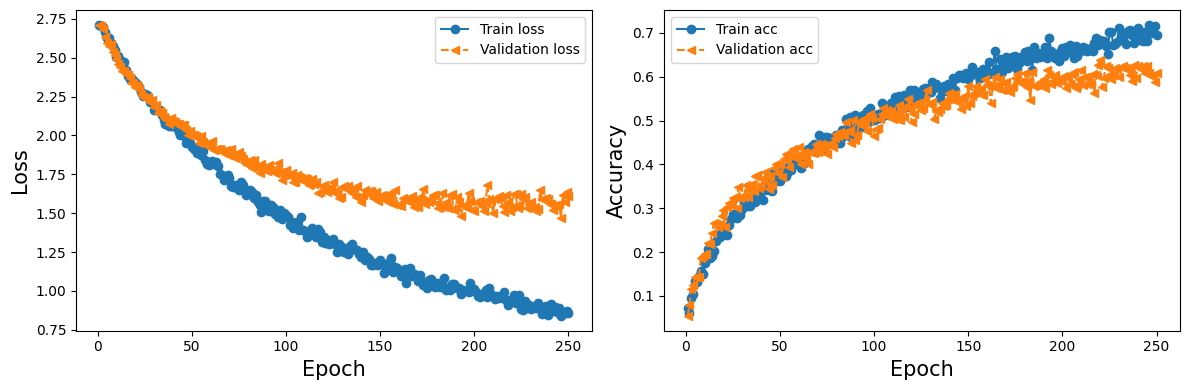

In [10]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, torch.tensor(hist[0]), "-o" ,label="Train loss")
ax.plot(x_arr, torch.tensor(hist[1]), "--<" ,label="Validation loss")
ax.legend(fontsize=10)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Loss", size=15)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, torch.tensor(hist[2]), "-o", label="Train acc")
ax.plot(x_arr, torch.tensor(hist[3]), "--<", label="Validation acc")

ax.legend(fontsize=10)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Accuracy", size=15)
plt.tight_layout()
plt.show()

Evaluate the model and calculate the accuracy on the test set.

In [14]:
model.eval()  # Set the model to evaluation mode
device = "cpu"
model.to(device)

total_correct = 0
total_images = 0

with torch.no_grad():
    for images, labels in test_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        predictions = model(images)
        predicted_labels = torch.argmax(predictions, dim=1)
        total_correct += (predicted_labels == labels).sum().item()
        total_images += labels.size(0)

test_accuracy = total_correct / total_images
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.5979


Time to plot some of the images from the test dataloader and their predicted labels for a visulization of the models performance. 

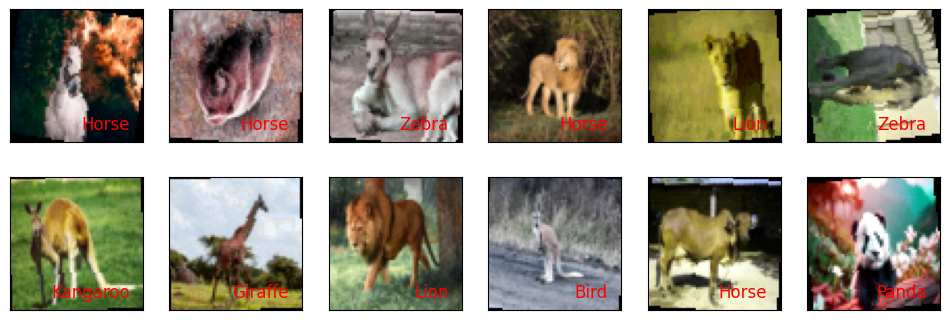

In [16]:
fig = plt.figure(figsize=(12, 4))

# We will visualize the first 12 images from the test dataset
for i, (images, labels) in enumerate(test_data_loader):
    if i >= 12:  # We only want the first 12 images
        break
    ax = fig.add_subplot(2, 6, i + 1)
    ax.set_xticks([]); ax.set_yticks([])

    # Prepare the image for display
    img = images[0].numpy().transpose((1, 2, 0))  # Change CxHxW to HxWxC for plotting
    img = (img - img.min()) / (img.max() - img.min())  # Scale image to [0, 1] for correct display

    # Prepare the image for prediction (no change needed if DataLoader already does it)
    img_tensor = images[0].unsqueeze(0).to(device)

    # Get the prediction
    with torch.no_grad():
        pred = model(img_tensor)
    y_pred = torch.argmax(pred, dim=1)

    names = ["Bear", "Bird","Cat","Cow","Deer", "Dog", "Dolphin", "Elephant", "Giraffe","Horse","Kangaroo","Lion","Panda", "Tiger","Zebra"]
    
    # Show the image
    ax.imshow(img)
    ax.text(0.9, 0.1, f'{names[int(y_pred.item())]}', size=12, color="Red", horizontalalignment='right', transform=ax.transAxes)

plt.show()

# Conclusion
I took a small dataset of labeled images of 15 classes of animals and passed them through an augmentation step before entering into a convolutional neural network to create a model for predicting their classes.

Area to improve:
One issue I keep running into is the model always seems to stick at around a 0.6 on the validation accuracy even with the introduction on of regularisation steps like dropout and increasing the augmentation steps to prevent overfitting.

### Save the model

In [15]:
torch.save(model.state_dict(), 'model_state.pth')